# Prophet Prediction

In [1]:
# Libraries
import pandas as pd
import numpy as np
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns



In [3]:
# Loading dataset
dataframe = pd.read_csv('/content/drive/My Drive/Class/Nephron Project/Data/Processed data/drugs_pct_changes_monthly.csv')

# Only NDCs that have full period
last_period = dataframe[(dataframe.Year == 2020) & (dataframe.Month == 7)].NDC.unique()
first_period = dataframe[(dataframe.Year == 2014) & (dataframe.Month == 8)].NDC.unique()
dataframe.Date = pd.to_datetime(dataframe.Date, format='%Y_%m')
selected_NDC = list(set(last_period).intersection(first_period)) 
dataframe = dataframe[dataframe.NDC.isin(selected_NDC)]

# Dropping NA
# dataframe = dataframe.dropna()
# print("shape: ", dataframe.shape)

# Dropping before 2015 because 2014 is not good
dataframe = dataframe[dataframe.Date >= pd.to_datetime('2015-01-01')]

dataframe.head()


,NDC,Manufacturer,Product,Product Launch Date,Estimated LOE Date,Major Class,Acute/Chronic,Prod Form,Pack Size,Pack Quantity,Date,Year,Month,TRx,Previous_TRx,TRx_cumulative,WAC,Pct_change,Changed
605,2322730,Eli Lilly and Co,STRATTERA 12/2002 LLY,12/1/2002 0:00,May-17,ADHD,CHRONIC,ORALS,1,30.0,2015-01-01,2015,1,11297,11566.0,11297.0,9.29,0.000000,0
606,2322730,Eli Lilly and Co,STRATTERA 12/2002 LLY,12/1/2002 0:00,May-17,ADHD,CHRONIC,ORALS,1,30.0,2015-02-01,2015,2,10622,11297.0,21919.0,9.29,0.000000,0
607,2322730,Eli Lilly and Co,STRATTERA 12/2002 LLY,12/1/2002 0:00,May-17,ADHD,CHRONIC,ORALS,1,30.0,2015-03-01,2015,3,12012,10622.0,33931.0,9.29,0.000000,0
608,2322730,Eli Lilly and Co,STRATTERA 12/2002 LLY,12/1/2002 0:00,May-17,ADHD,CHRONIC,ORALS,1,30.0,2015-04-01,2015,4,11520,12012.0,45451.0,9.29,0.000000,0
609,2322730,Eli Lilly and Co,STRATTERA 12/2002 LLY,12/1/2002 0:00,May-17,ADHD,CHRONIC,ORALS,1,30.0,2015-05-01,2015,5,10866,11520.0,56317.0,10.21,0.099031,1


In [4]:
# Getting rid of NDC that do not have LOE date
# dataframe = dataframe[dataframe['Estimated LOE Date'] != 'Unspecified']

# Getting rid of NDC that are too close to their LOE date
# dataframe['Estimated LOE Date'] = pd.to_datetime(dataframe['Estimated LOE Date'], format='%b-%y')
# dataframe = dataframe[dataframe['Estimated LOE Date'] >= pd.to_datetime('2020-07-01')]

In [5]:
classes = dataframe['Major Class'].unique()
classes

array(['ADHD', 'OTHER CNS', 'MENTAL HEALTH', 'ERECTILE DYSFUNCTION',
       'ANTICOAGULANTS', 'ANTIDIABETICS', 'ONCOLOGICS', 'OSTEOPOROSIS',
       'VIRAL HEPATITIS', 'IMMUNOLOGY', 'ANTIBACTERIALS',
       'HIV ANTIVIRALS', 'LIPID REGULATORS', 'ANTIVIRALS, HERPES',
       'NERVOUS SYSTEM DISORDERS', 'IMMUNOSUPPRESSANTS',
       'COUGH COLD, INCL FLU ANTIVIRALS', 'VACCINES (PURE, COMB, OTHER)',
       'ANTI-PARASITICS, ANTIMALARIALS, INSECTICIDES', 'DERMATOLOGICS',
       'BPH (BENIGN PROSTATIC HYPERTROPHY)',
       'ANTIHYPERTENSIVES, PLAIN & COMBO', 'PAIN',
       'CANCER DETOX AG, ANTI-NAUSEANTS', 'RESPIRATORY AGENTS',
       'MIOTICS+ANTIGLAUCOMA PREPS', 'SYST ANTIFUNGALS', 'ANTI-ULCERANTS',
       'SEX HORMONES (ANDROGENS, OESTROGENS, PROGESTOGENS,',
       'ANTITUBERCULARS', 'CORTICOSTEROIDS, PLAIN & COMBO',
       'HORMONAL CONTRACEPTION, SYSTEMIC&TOPICAL', 'URINARY INCONTINENCE',
       'GENITO-URINARY ANTIBACTERIALS & ANTISEPTICS & ANTI',
       'GI PRODUCTS', 'OPHTHALMOLOGY, G

In [57]:
# Filtering for a single class
selected_class = 'PAIN'
data_class = dataframe[dataframe['Major Class'] == selected_class].copy()
print('Size: ', len(data_class))
data_class.head()


Size:  5080


,NDC,Manufacturer,Product,Product Launch Date,Estimated LOE Date,Major Class,Acute/Chronic,Prod Form,Pack Size,Pack Quantity,Date,Year,Month,TRx,Previous_TRx,TRx_cumulative,WAC,Pct_change,Changed
13706,6026718,Merck Sharp & Dohme Corp. a Subsidiary of Merc...,MAXALT 07/1998 MSD,7/1/1998 0:00,Dec-12,PAIN,ACUTE,ORALS,1,18.0,2015-01-01,2015,1,2579,3251.0,2579.0,34.53055,0.0,0
13707,6026718,Merck Sharp & Dohme Corp. a Subsidiary of Merc...,MAXALT 07/1998 MSD,7/1/1998 0:00,Dec-12,PAIN,ACUTE,ORALS,1,18.0,2015-02-01,2015,2,2386,2579.0,4965.0,34.53055,0.0,0
13708,6026718,Merck Sharp & Dohme Corp. a Subsidiary of Merc...,MAXALT 07/1998 MSD,7/1/1998 0:00,Dec-12,PAIN,ACUTE,ORALS,1,18.0,2015-03-01,2015,3,2637,2386.0,7602.0,34.53055,0.0,0
13709,6026718,Merck Sharp & Dohme Corp. a Subsidiary of Merc...,MAXALT 07/1998 MSD,7/1/1998 0:00,Dec-12,PAIN,ACUTE,ORALS,1,18.0,2015-04-01,2015,4,2328,2637.0,9930.0,34.53055,0.0,0
13710,6026718,Merck Sharp & Dohme Corp. a Subsidiary of Merc...,MAXALT 07/1998 MSD,7/1/1998 0:00,Dec-12,PAIN,ACUTE,ORALS,1,18.0,2015-05-01,2015,5,2385,2328.0,12315.0,34.53055,0.0,0


In [58]:
# Helper function to compute the weighted WAC 
def weigthed_average(data, quantity, weights):
    try:
        return (data[quantity] * data[weights]).sum() / data[weights].sum()
    except ZeroDivisionError:
        return data[quantity]


# Creating a sales column
data_class['Sales'] = data_class['WAC'] * data_class['TRx']
df = data_class.groupby('Date').apply(weigthed_average, 'WAC', 'Sales').to_frame(name = 'Sales weighted WAC')
# df['Sales weighted previous TRx'] = data_class.groupby('Date').apply(weigthed_average, 'Previous_TRx', 'Sales')
# df['Sales weighted cumulative TRx'] = data_class.groupby('Date').apply(weigthed_average, 'TRx_cumulative', 'Sales')
# df['Sales weighted log cumulative TRx'] = np.log(data_class.groupby('Date').apply(weigthed_average, 'TRx_cumulative', 'Sales'))
df.reset_index(inplace=True)
df.head()

,Date,Sales weighted WAC
0,2015-01-01,43.659160
1,2015-02-01,47.485471
2,2015-03-01,48.205759
3,2015-04-01,46.906402
4,2015-05-01,47.197432


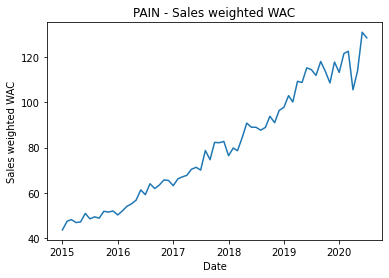

In [59]:
sns.lineplot(x=df.Date, y=df['Sales weighted WAC'])
plt.title(f'{selected_class} - Sales weighted WAC')
plt.show()

# sns.lineplot(x=df.Date, y=df['Sales weighted cumulative TRx'])
# plt.title(f'{selected_class} - Sales weighted cumulative Trx')
# plt.show()

# sns.lineplot(x=df.Date, y=df['Sales weighted previous TRx'])
# plt.title(f'{selected_class} - Sales weighted previous Trx')
# plt.show()

Total number of drugs in this class:  76


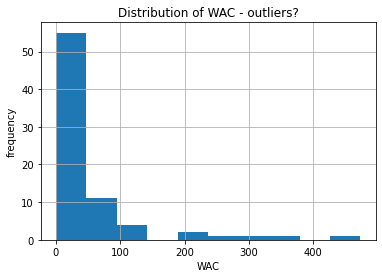

In [60]:
print('Total number of drugs in this class: ', data_class.NDC.nunique())

data_class.groupby('NDC').WAC.mean().hist()
plt.title('Distribution of WAC - outliers?')
plt.xlabel('WAC')
plt.ylabel('frequency')
plt.show()

# Prophet Model

In [61]:
def prophet_model(data, test_date=None, prediction_period=365, changepoint_prior_scale=.05):

    # Initiating test variable
    test_set = None

    # Reformating dataset for prophet
    df_prophet = data[['Date', 'Sales weighted WAC']].copy()
    df_prophet = df_prophet.rename(columns={'Date': 'ds', 'Sales weighted WAC': 'y'})

    # Creating Prophet model
    model = Prophet(changepoint_prior_scale=changepoint_prior_scale, daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True)

    # Fitting model to training data excluding test dates
    if test_date is not None:
        model.fit(df_prophet[df_prophet.ds < pd.to_datetime(test_date)])
    else:
        model.fit(df_prophet)

    # Building predictions for train and test dates
    future = model.make_future_dataframe(periods=prediction_period, freq='MS')
    forecast = model.predict(future)

    # Ordering columns
    forecast = forecast[['ds', 'yhat'] + [c for c in forecast if c not in ['ds', 'yhat']]]

    # Creating test period dataset only
    if test_date is not None:
        forecast_test = model.predict(df_prophet)
        forecast_test['y'] = data['Sales weighted WAC'].values
        test_set = forecast_test[forecast_test.ds >= pd.to_datetime(test_date)][['ds', 'y', 'yhat']].copy()
        
    # Return model (for plotting), full forecast, and test period dataset
    return model, forecast, test_set

MAE on test period:  7.596842900297904


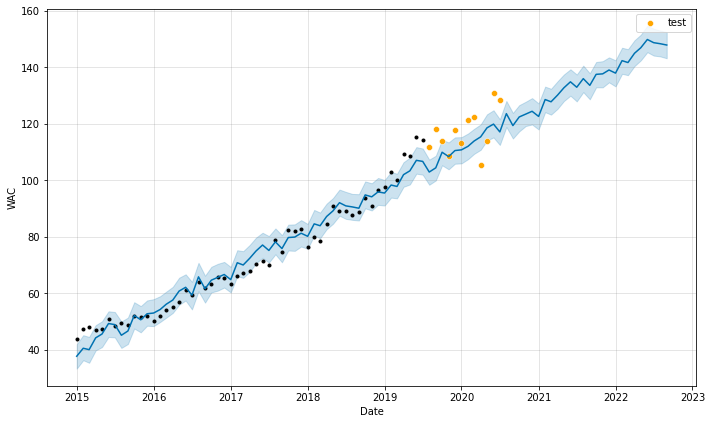

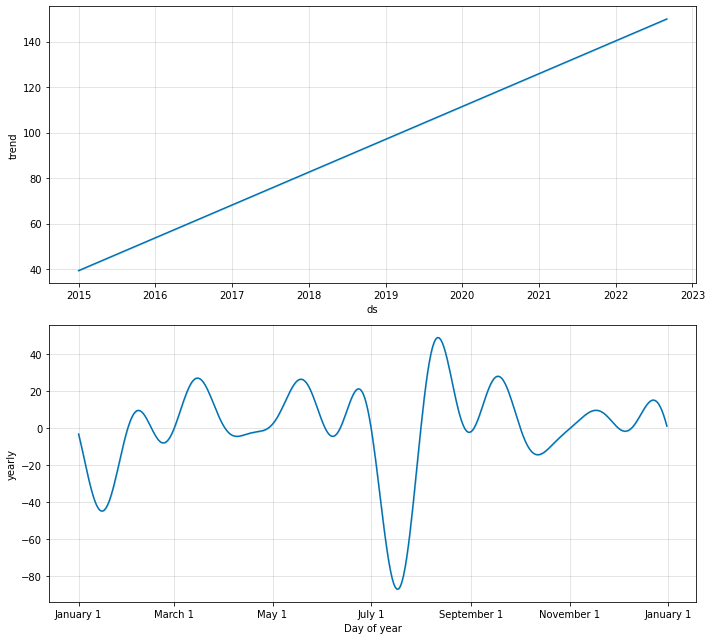

In [64]:
model, forecast, test_set = prophet_model(data=df, test_date='2019-08-01', prediction_period=38, changepoint_prior_scale=.005)

# plotting results
fig, ax = plt.subplots(figsize=(10, 6))
model.plot(forecast, ax=ax);
if test_set is not None:
    sns.scatterplot(x= test_set.ds, y=test_set.y, color='orange', label='test')
    plt.legend()
    print('MAE on test period: ', mean_absolute_error(test_set.y, test_set.yhat))

plt.xlabel('Date')
plt.ylabel('WAC')
plt.show()


# plotting components
model.plot_components(forecast, figsize=(10, 9))
plt.show()


In [63]:
# forecast.to_csv('Oncologics.csv', index=False)

# Regressors

In [ ]:
def prophet_predict_regressor(data, test_date, regressors=None, changepoint_prior_scale=.05):

    # Reformating dataset for prophet
    if regressors is not None:
        df_prophet = data[['Date', 'Sales weighted WAC'] + [reg for reg in regressors]].copy()
    else:
        df_prophet = data[['Date', 'Sales weighted WAC']].copy()
    df_prophet = df_prophet.rename(columns={'Date': 'ds', 'Sales weighted WAC': 'y'})

    # Creating Prophet model
    model = Prophet(changepoint_prior_scale=changepoint_prior_scale, daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True)

    # Adding regressor if not None
    if regressors is not None:
        for reg in regressors:
            model.add_regressor(reg)

    # Fitting model to training data excluding test dates
    model.fit(df_prophet[df_prophet.ds <= pd.to_datetime(test_date)])

    # Building predictions for train and test dates
    if regressors is not None:
        forecast = model.predict(df_prophet[['ds'] + [reg for reg in regressors]])
    else:   
        forecast = model.predict(df_prophet['ds'].to_frame())
    
    # Extracting the real values from original dataset
    forecast['y'] = data['Sales weighted WAC'].values
    # Ordering columns
    forecast = forecast[['ds', 'y', 'yhat'] + [c for c in forecast if c not in ['ds', 'y', 'yhat']]]

    # Creating test period dataset only
    test = forecast[forecast.ds > pd.to_datetime(test_date)][['ds', 'y', 'yhat']].copy()

    # Return model (for plotting), full forecast, and test period dataset
    return model, forecast, test

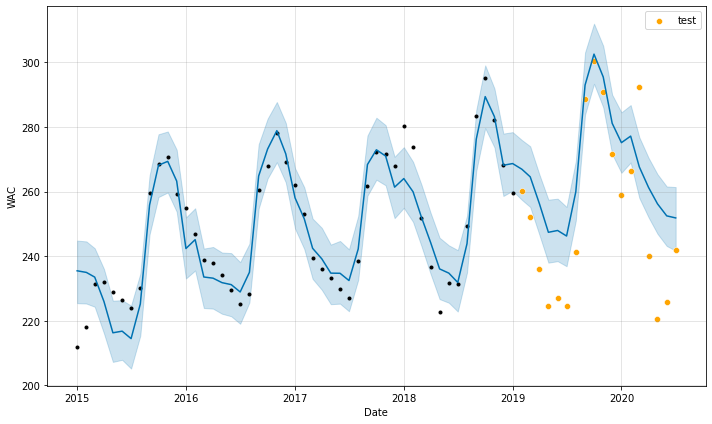

MAE on test period:  16.063932914329648


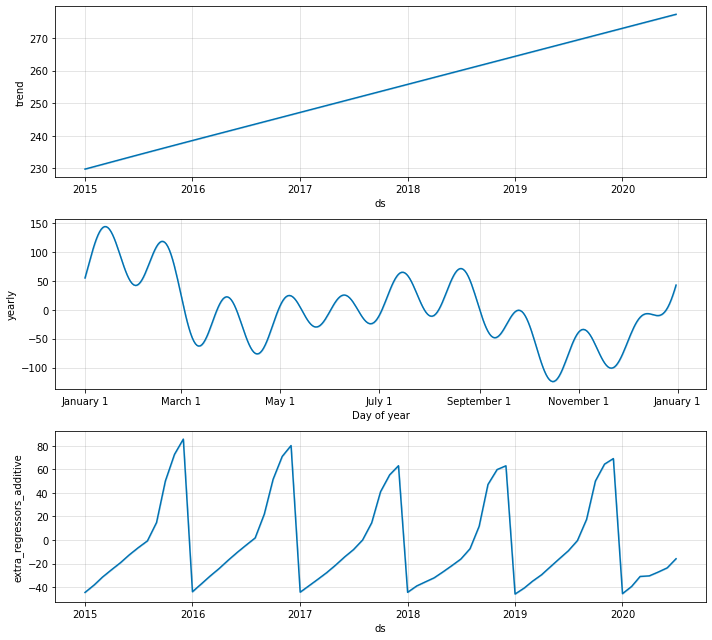

In [ ]:
model, forecast, test = prophet_predict_regressor(data=df, regressors=['Sales weighted cumulative TRx'], test_date='2019-1-1', changepoint_prior_scale=.05)

# plotting results
fig, ax = plt.subplots(figsize=(10, 6))
model.plot(forecast, ax=ax);
sns.scatterplot(x= test.ds, y=test.y, color='orange', label='test')
plt.legend()
plt.xlabel('Date')
plt.ylabel('WAC')
plt.show()

# Computing MAE
print('MAE on test period: ', mean_absolute_error(test.y, test.yhat))

# plotting components
model.plot_components(forecast, figsize=(10, 9))
plt.show()

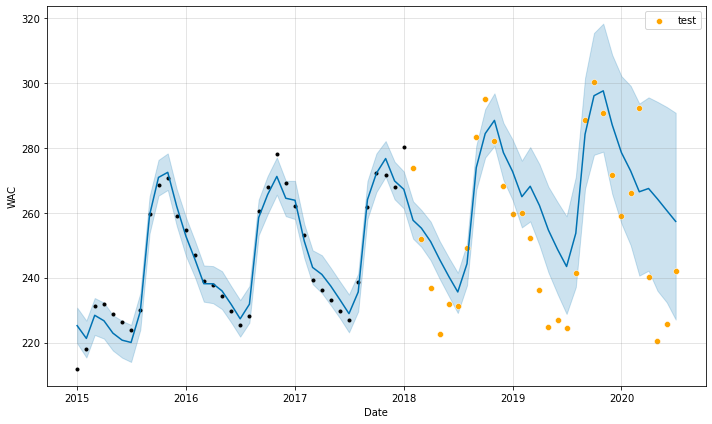

MAE on test period:  15.318519603317684


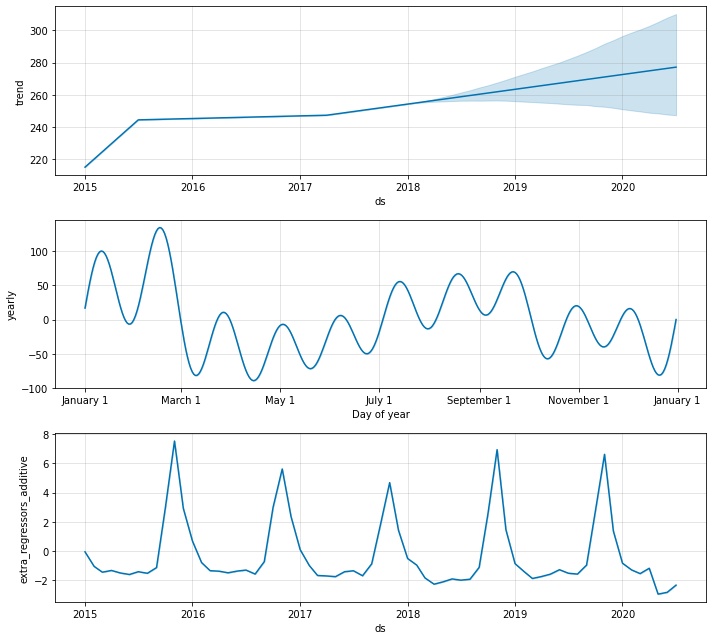

In [ ]:
model, forecast, test = prophet_predict_regressor(data=df, regressors=['Sales weighted previous TRx'], test_date='2018-1-1', changepoint_prior_scale=.05)

# plotting results
fig, ax = plt.subplots(figsize=(10, 6))
model.plot(forecast, ax=ax);
sns.scatterplot(x= test.ds, y=test.y, color='orange', label='test')
plt.legend()
plt.xlabel('Date')
plt.ylabel('WAC')
plt.show()

# Computing MAE
print('MAE on test period: ', mean_absolute_error(test.y, test.yhat))

# plotting components
model.plot_components(forecast, figsize=(10, 9))
plt.show()

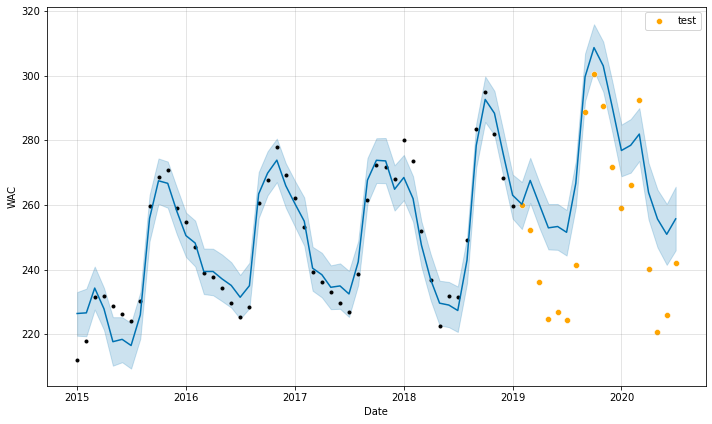

MAE on test period:  18.59631887639501


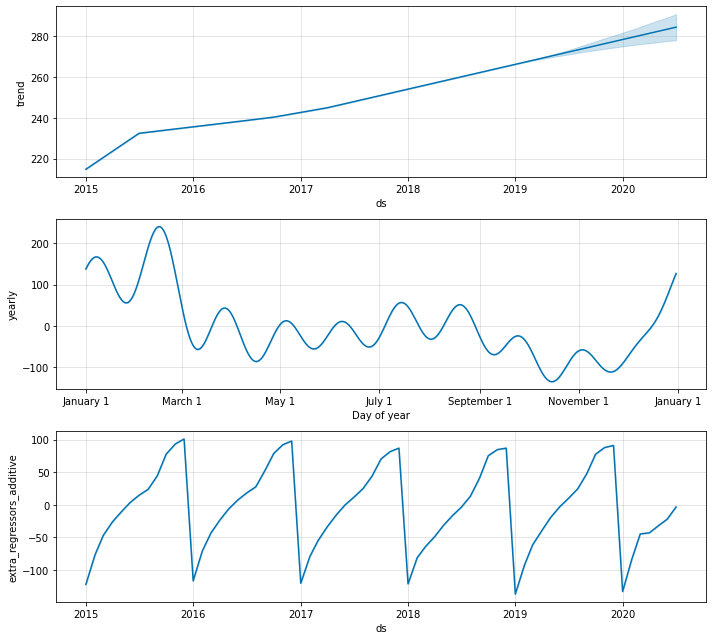

In [ ]:
model, forecast, test = prophet_predict_regressor(data=df, regressors=['Sales weighted log cumulative TRx'], test_date='2019-1-1', changepoint_prior_scale=.05)

# plotting results
fig, ax = plt.subplots(figsize=(10, 6))
model.plot(forecast, ax=ax);
sns.scatterplot(x= test.ds, y=test.y, color='orange', label='test')
plt.legend()
plt.xlabel('Date')
plt.ylabel('WAC')
plt.show()

# Computing MAE
print('MAE on test period: ', mean_absolute_error(test.y, test.yhat))

# plotting components
model.plot_components(forecast, figsize=(10, 9))
plt.show()

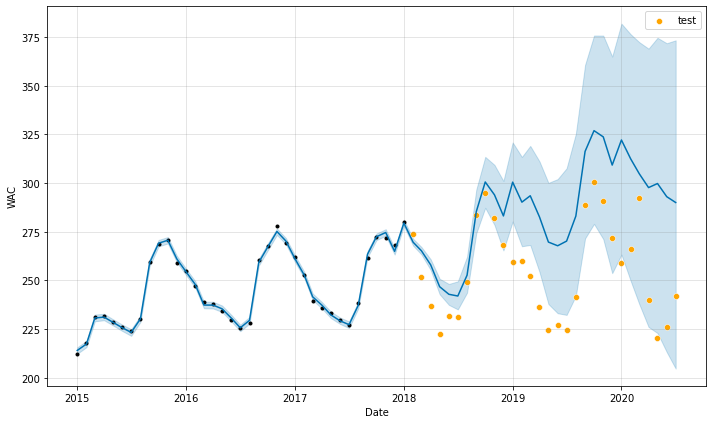

MAE on test period:  31.77394433991673


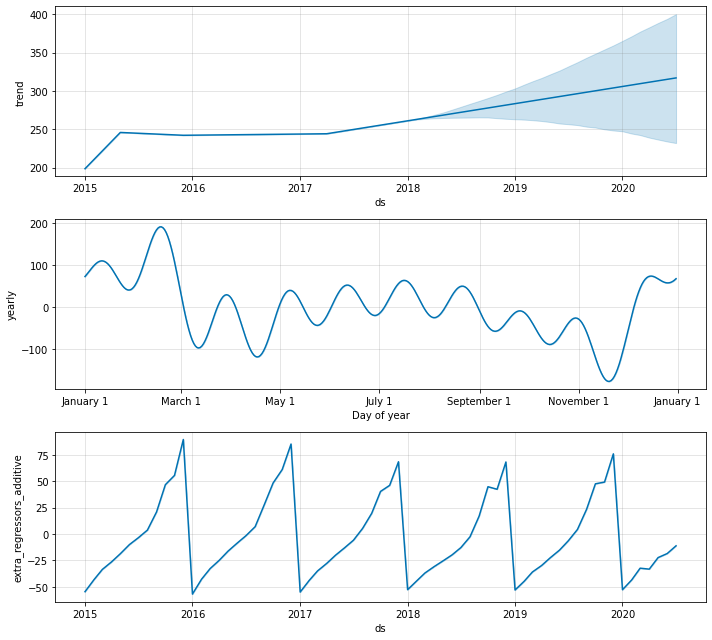

In [ ]:
model, forecast, test = prophet_predict_regressor(data=df, regressors=['Sales weighted cumulative TRx', 'Sales weighted previous TRx'], test_date='2018-1-1', changepoint_prior_scale=.05)

# plotting results
fig, ax = plt.subplots(figsize=(10, 6))
model.plot(forecast, ax=ax);
sns.scatterplot(x= test.ds, y=test.y, color='orange', label='test')
plt.legend()
plt.xlabel('Date')
plt.ylabel('WAC')
plt.show()

# Computing MAE
print('MAE on test period: ', mean_absolute_error(test.y, test.yhat))

# plotting components
model.plot_components(forecast, figsize=(10, 9))
plt.show()